In [1]:

import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset 
from torch.utils.data import DataLoader
import torch.utils
import sklearn
from sklearn.model_selection import train_test_split #将数据划分为训练数据及验证数据
import torchvision
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms
from torch.autograd import Variable
import os
%matplotlib inline
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import joblib
import time
from sklearn.manifold import TSNE
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题
import scipy.io
from scipy.signal import resample
from scipy import fftpack

import matplotlib.cm as cm
cmap = cm.cool(np.linspace(0.3, 1, 8))

In [2]:
data = pd.read_csv(r'F:\\白鸽子的表.csv')

DTT , Factor_1, Factor_2, Factor_3, Factor_4= data['DTT'].values, data['Factor 1'].values, data['Factor 2'].values, data['Factor 3'].values, data['Factor 4'].values

Epoch [50/5000], Loss: 0.8379
Epoch [100/5000], Loss: 0.7955
Epoch [150/5000], Loss: 0.7916
Epoch [200/5000], Loss: 0.7915
Epoch [250/5000], Loss: 0.7915
Epoch [300/5000], Loss: 0.7915
Epoch [350/5000], Loss: 0.7915
Epoch [400/5000], Loss: 0.7915
Epoch [450/5000], Loss: 0.7915
Epoch [500/5000], Loss: 0.7915
Epoch [550/5000], Loss: 0.7915
Epoch [600/5000], Loss: 0.7915
Epoch [650/5000], Loss: 0.7915
Epoch [700/5000], Loss: 0.7915
Epoch [750/5000], Loss: 0.7915
Epoch [800/5000], Loss: 0.7915
Epoch [850/5000], Loss: 0.7915
Epoch [900/5000], Loss: 0.7915
Epoch [950/5000], Loss: 0.7915
Epoch [1000/5000], Loss: 0.7915
Epoch [1050/5000], Loss: 0.7915
Epoch [1100/5000], Loss: 0.7915
Epoch [1150/5000], Loss: 0.7915
Epoch [1200/5000], Loss: 0.7915
Epoch [1250/5000], Loss: 0.7915
Epoch [1300/5000], Loss: 0.7915
Epoch [1350/5000], Loss: 0.7915
Epoch [1400/5000], Loss: 0.7915
Epoch [1450/5000], Loss: 0.7915
Epoch [1500/5000], Loss: 0.7915
Epoch [1550/5000], Loss: 0.7915
Epoch [1600/5000], Loss: 0.7

C:\Users\admin\AppData\Local\Temp\ipykernel_7360\2678392179.py:123: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  plt.tight_layout()
C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


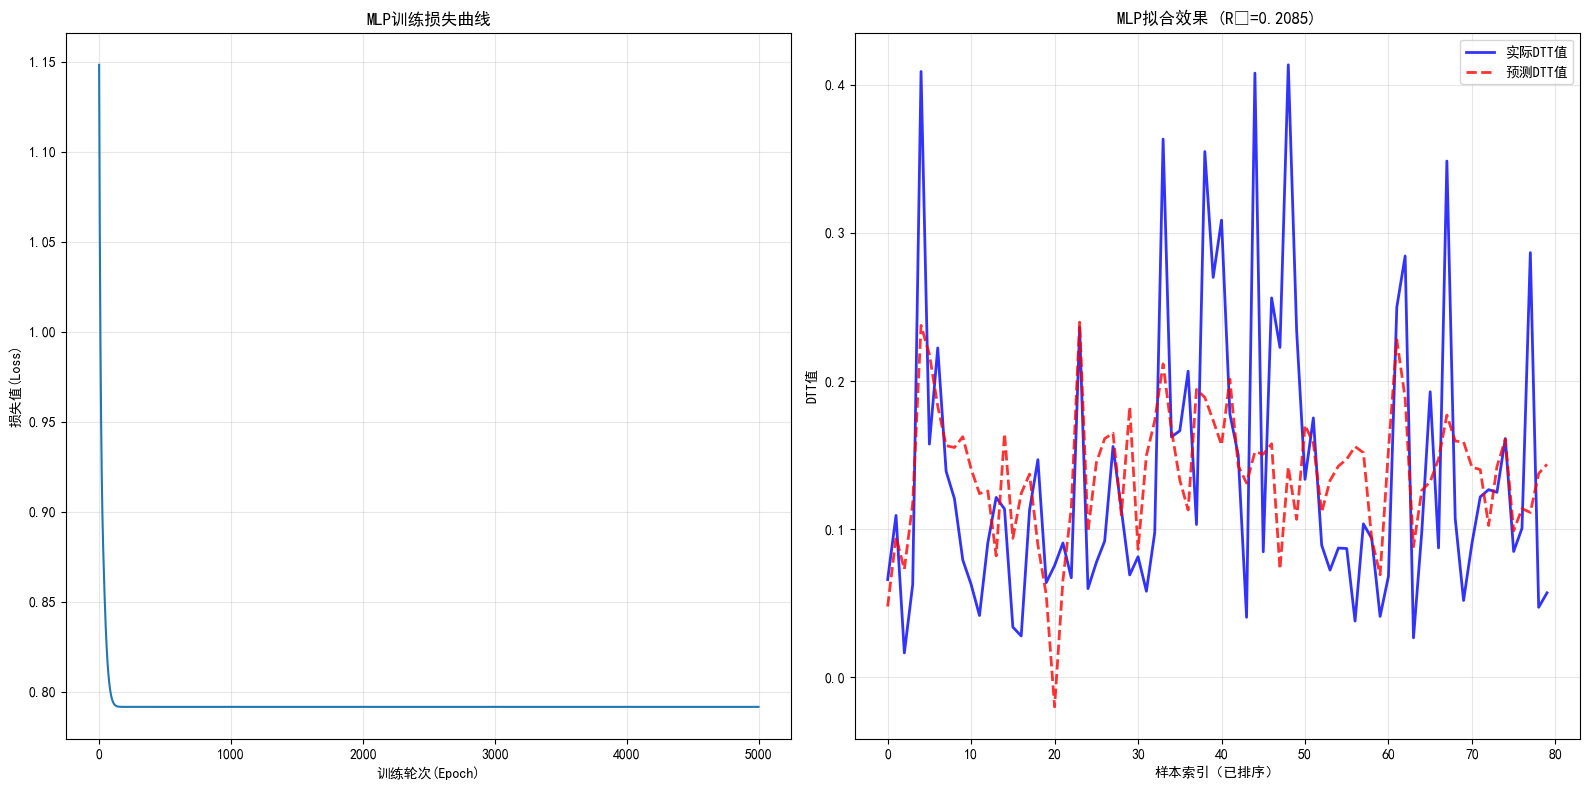

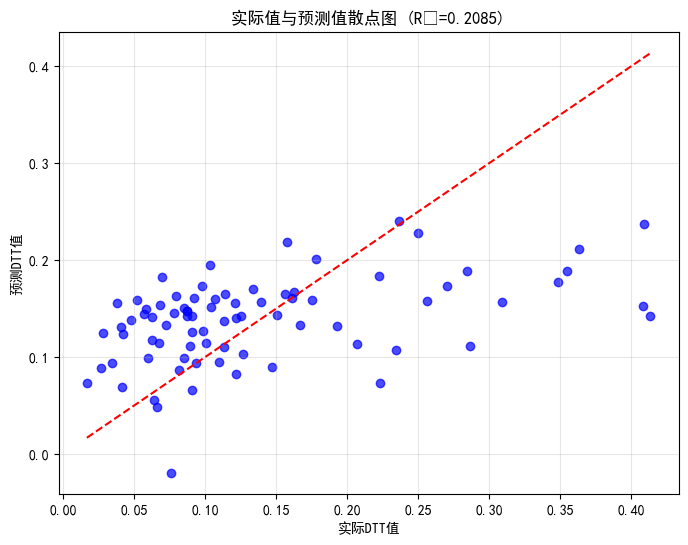

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error


# 创建DataFrame
data = pd.DataFrame({
    'DTT': DTT.reshape(-1),
    'Factor 1': Factor_1.reshape(-1),
    'Factor 2': Factor_2.reshape(-1),
    'Factor 3': Factor_3.reshape(-1),
    'Factor 4': Factor_4.reshape(-1)
})

# 提取变量
X = data[['Factor 1', 'Factor 2', 'Factor 3', 'Factor 4']].values
y = data['DTT'].values

# 数据标准化（重要！神经网络对输入尺度敏感）
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_std = X_scaler.fit_transform(X)
y_std = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

# 转换为PyTorch张量
X_tensor = torch.FloatTensor(X_std)
y_tensor = torch.FloatTensor(y_std)

# 定义MLP模型
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.layer1 = nn.Linear(input_dim, output_dim)
        self.relu = nn.ReLU()
        # self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = (self.layer1(x))
        # x = self.relu(self.layer2(x))
        # x = self.layer3(x)
        return x

# 初始化模型
input_dim = X.shape[1]
hidden_dim = 10  # 隐藏层神经元数量
output_dim = 1   # 输出维度（DTT预测值）
model = SimpleMLP(input_dim, hidden_dim, output_dim)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 训练模型
epochs = 5000
losses = []

for epoch in range(epochs):
    # 前向传播
    outputs = model(X_tensor).squeeze()
    loss = criterion(outputs, y_tensor)
    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 记录损失
    losses.append(loss.item())
    
    # 打印训练进度
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# 模型评估（在全数据集上）
model.eval()
with torch.no_grad():
    y_pred_std = model(X_tensor).squeeze().numpy()
    # 反标准化预测值
    y_pred = y_scaler.inverse_transform(y_pred_std.reshape(-1, 1)).flatten()
    y_true = y

# 计算评估指标
r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true - y_pred))

print(f"\nMLP模型评估指标:")
print(f"决定系数(R²): {r2:.4f}")
print(f"均方误差(MSE): {mse:.4f}")
print(f"均方根误差(RMSE): {rmse:.4f}")
print(f"平均绝对误差(MAE): {mae:.4f}")

# 可视化训练过程和拟合效果
plt.figure(figsize=(16, 8))

# 1. 训练损失曲线
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('训练轮次(Epoch)')
plt.ylabel('损失值(Loss)')
plt.title('MLP训练损失曲线')
plt.grid(True, alpha=0.3)

# 2. 实际值与预测值分别绘制（按顺序排列）
plt.subplot(1, 2, 2)
# 排序以便观察趋势
sort_idx = np.argsort(np.arange(len(y_true)))
plt.plot(y_true[sort_idx], label='实际DTT值', color='blue', linewidth=2, alpha=0.8)
plt.plot(y_pred[sort_idx], label='预测DTT值', color='red', linewidth=2, alpha=0.8, linestyle='--')
plt.xlabel('样本索引（已排序）')
plt.ylabel('DTT值')
plt.title(f'MLP拟合效果 (R²={r2:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 额外：实际值vs预测值散点图
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.7, color='blue')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel('实际DTT值')
plt.ylabel('预测DTT值')
plt.title(f'实际值与预测值散点图 (R²={r2:.4f})')
plt.grid(True, alpha=0.3)
plt.show()

Epoch [50/3000], Loss: 0.6092
Epoch [100/3000], Loss: 0.5001
Epoch [150/3000], Loss: 0.3070
Epoch [200/3000], Loss: 0.2233
Epoch [250/3000], Loss: 0.1941
Epoch [300/3000], Loss: 0.1662
Epoch [350/3000], Loss: 0.1503
Epoch [400/3000], Loss: 0.1329
Epoch [450/3000], Loss: 0.1228
Epoch [500/3000], Loss: 0.1043
Epoch [550/3000], Loss: 0.0883
Epoch [600/3000], Loss: 0.0813
Epoch [650/3000], Loss: 0.0681
Epoch [700/3000], Loss: 0.0621
Epoch [750/3000], Loss: 0.0581
Epoch [800/3000], Loss: 0.0530
Epoch [850/3000], Loss: 0.0511
Epoch [900/3000], Loss: 0.0468
Epoch [950/3000], Loss: 0.0444
Epoch [1000/3000], Loss: 0.0432
Epoch [1050/3000], Loss: 0.0421
Epoch [1100/3000], Loss: 0.0388
Epoch [1150/3000], Loss: 0.0378
Epoch [1200/3000], Loss: 0.0365
Epoch [1250/3000], Loss: 0.0354
Epoch [1300/3000], Loss: 0.0346
Epoch [1350/3000], Loss: 0.0335
Epoch [1400/3000], Loss: 0.0399
Epoch [1450/3000], Loss: 0.0328
Epoch [1500/3000], Loss: 0.0327
Epoch [1550/3000], Loss: 0.0320
Epoch [1600/3000], Loss: 0.0

C:\Users\admin\AppData\Local\Temp\ipykernel_7360\523346640.py:123: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  plt.tight_layout()
C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


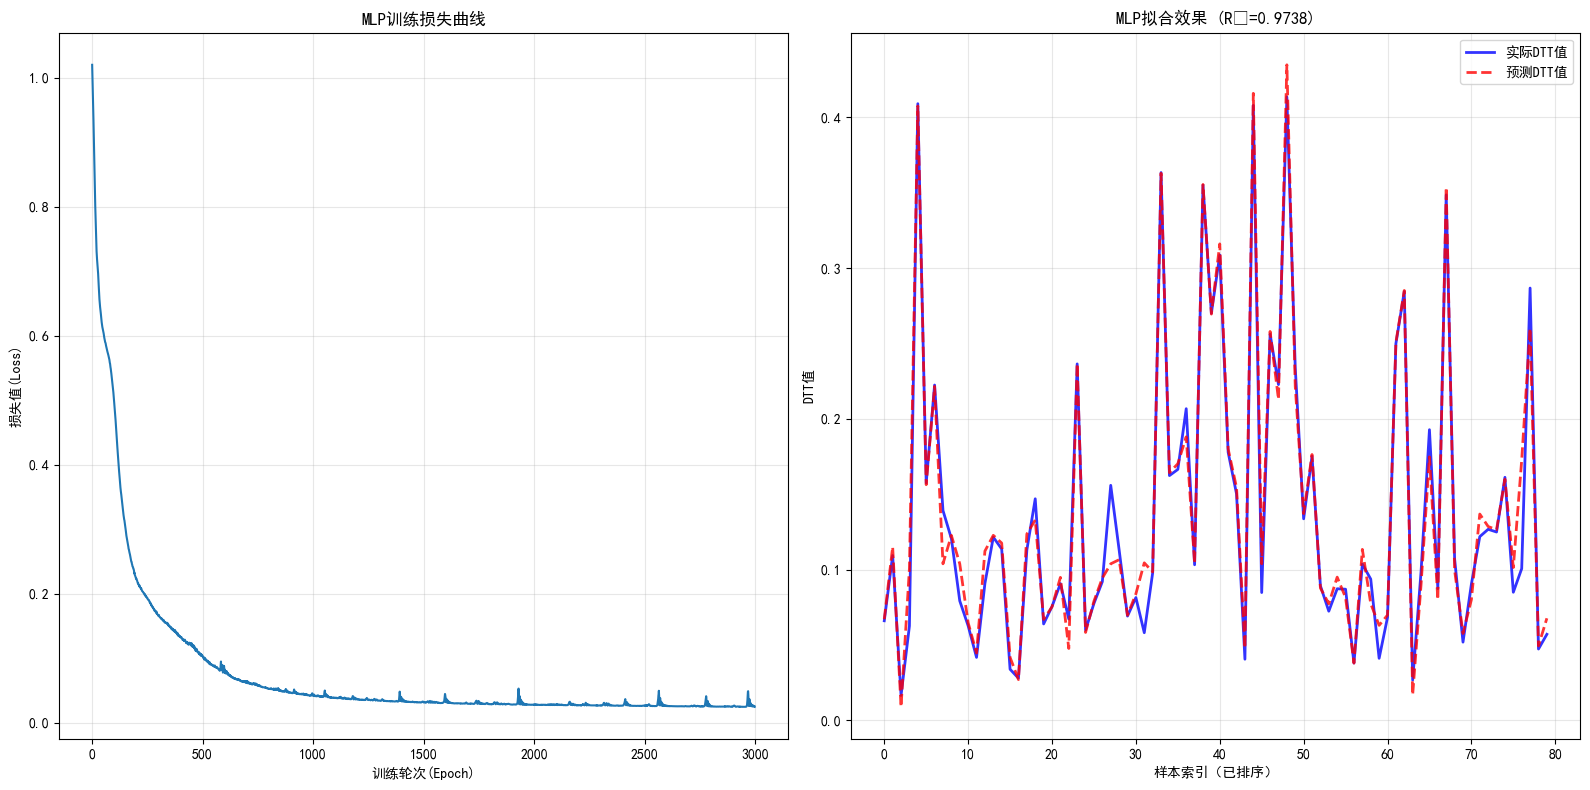

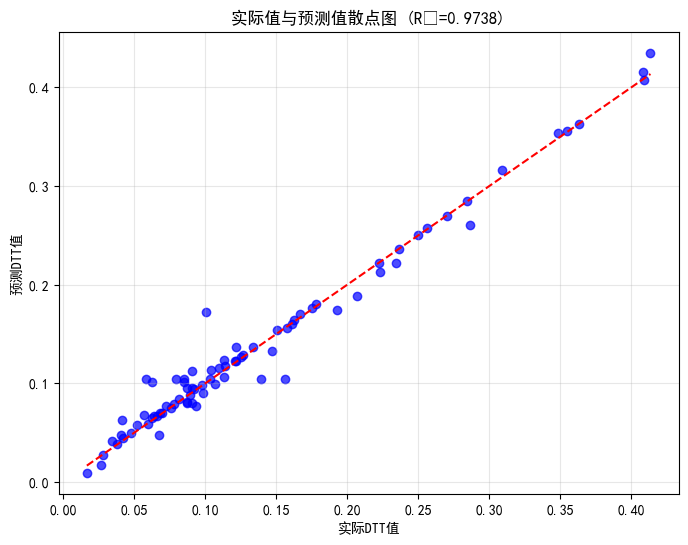

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error


# 创建DataFrame
data = pd.DataFrame({
    'DTT': DTT.reshape(-1),
    'Factor 1': Factor_1.reshape(-1),
    'Factor 2': Factor_2.reshape(-1),
    'Factor 3': Factor_3.reshape(-1),
    'Factor 4': Factor_4.reshape(-1)
})

# 提取变量
X = data[['Factor 1', 'Factor 2', 'Factor 3', 'Factor 4']].values
y = data['DTT'].values

# 数据标准化（重要！神经网络对输入尺度敏感）
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_std = X_scaler.fit_transform(X)
y_std = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

# 转换为PyTorch张量
X_tensor = torch.FloatTensor(X_std)
y_tensor = torch.FloatTensor(y_std)

# 定义MLP模型
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# 初始化模型
input_dim = X.shape[1]
hidden_dim = 10  # 隐藏层神经元数量
output_dim = 1   # 输出维度（DTT预测值）
model = SimpleMLP(input_dim, hidden_dim, output_dim)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 训练模型
epochs = 3000
losses = []

for epoch in range(epochs):
    # 前向传播
    outputs = model(X_tensor).squeeze()
    loss = criterion(outputs, y_tensor)
    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 记录损失
    losses.append(loss.item())
    
    # 打印训练进度
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# 模型评估（在全数据集上）
model.eval()
with torch.no_grad():
    y_pred_std = model(X_tensor).squeeze().numpy()
    # 反标准化预测值
    y_pred = y_scaler.inverse_transform(y_pred_std.reshape(-1, 1)).flatten()
    y_true = y

# 计算评估指标
r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true - y_pred))

print(f"\nMLP模型评估指标:")
print(f"决定系数(R²): {r2:.4f}")
print(f"均方误差(MSE): {mse:.4f}")
print(f"均方根误差(RMSE): {rmse:.4f}")
print(f"平均绝对误差(MAE): {mae:.4f}")

# 可视化训练过程和拟合效果
plt.figure(figsize=(16, 8))

# 1. 训练损失曲线
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('训练轮次(Epoch)')
plt.ylabel('损失值(Loss)')
plt.title('MLP训练损失曲线')
plt.grid(True, alpha=0.3)

# 2. 实际值与预测值分别绘制（按顺序排列）
plt.subplot(1, 2, 2)
# 排序以便观察趋势
sort_idx = np.argsort(np.arange(len(y_true)))
plt.plot(y_true[sort_idx], label='实际DTT值', color='blue', linewidth=2, alpha=0.8)
plt.plot(y_pred[sort_idx], label='预测DTT值', color='red', linewidth=2, alpha=0.8, linestyle='--')
plt.xlabel('样本索引（已排序）')
plt.ylabel('DTT值')
plt.title(f'MLP拟合效果 (R²={r2:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 额外：实际值vs预测值散点图
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.7, color='blue')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel('实际DTT值')
plt.ylabel('预测DTT值')
plt.title(f'实际值与预测值散点图 (R²={r2:.4f})')
plt.grid(True, alpha=0.3)
plt.show()

In [19]:
import shap

# 模型设置为评估模式
model.eval()

# 选择背景数据
background = X_tensor.requires_grad_()

# 使用 GradientExplainer（注意是 list 类型）
explainer = shap.GradientExplainer(model, background)

# 计算 SHAP 值（Tensor -> numpy）
shap_values = explainer.shap_values(X_tensor)

# shap_values 是一个 list（单输出变量时取第一个）
shap_values_array = shap_values# [0]# .reshape(1,-1)# .numpy()


C:\Users\admin\AppData\Local\Temp\ipykernel_7360\3196787059.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_2d, features=X, feature_names=data.columns[1:], plot_type="bar")


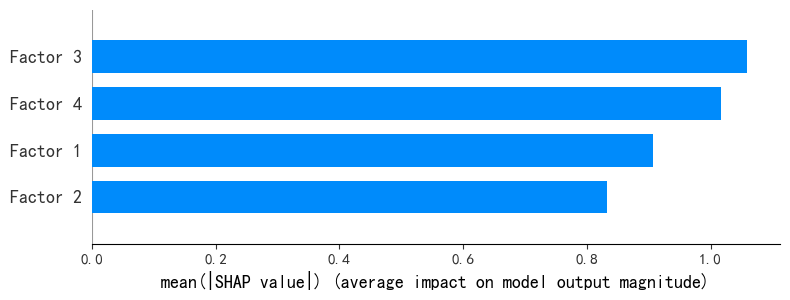

C:\Users\admin\AppData\Local\Temp\ipykernel_7360\3196787059.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_2d, features=X, feature_names=data.columns[1:])


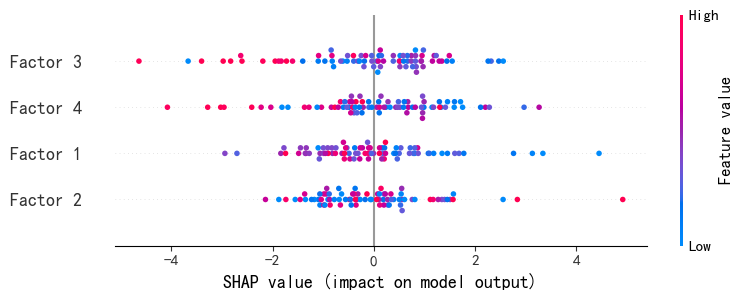

In [20]:
# 取出第一个输出维度（因为是回归任务，只有一个输出）
shap_values_2d = shap_values[:, :, 0]  # shape: (80, 4)

# 然后再可视化
shap.summary_plot(shap_values_2d, features=X, feature_names=data.columns[1:], plot_type="bar")
shap.summary_plot(shap_values_2d, features=X, feature_names=data.columns[1:])


In [11]:
shap_values_2d

array([[-8.71574998e-02, -1.26539672e+00,  7.16356484e-01,
        -6.54530519e-01],
       [-6.30083451e-01,  1.10312568e+00,  1.14485483e-01,
         3.26030494e-02],
       [-1.90945631e+00, -4.16422446e-01,  1.58095329e-01,
         3.20409424e-01],
       [-1.08635281e+00,  3.00856004e-01,  7.18132786e-01,
        -3.16220142e-01],
       [ 2.74764994e+00,  1.71746877e+00, -3.40897753e+00,
         4.51655779e-02],
       [-7.44287422e-02,  2.07636379e+00, -2.42457192e+00,
         2.30397825e-01],
       [ 2.73170101e+00,  2.59701314e-01, -3.41492062e+00,
         2.07482070e+00],
       [ 6.56810909e-01, -2.12448945e-01, -7.35028096e-01,
         1.27232852e+00],
       [ 2.74132252e-01, -1.01052288e-02,  5.33105230e-01,
        -3.26720859e-01],
       [-4.73393108e-01, -1.75174460e+00, -2.12544241e-01,
         6.52381224e-01],
       [-9.48440544e-03, -5.45444975e-01,  2.92078242e-01,
        -2.58053078e-01],
       [-1.28368873e+00, -6.71376492e-01,  5.75016019e-01,
      

C:\Users\admin\AppData\Local\Temp\ipykernel_7360\1436011745.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_positive_only, features=X, feature_names=data.columns[1:], plot_type="dot")


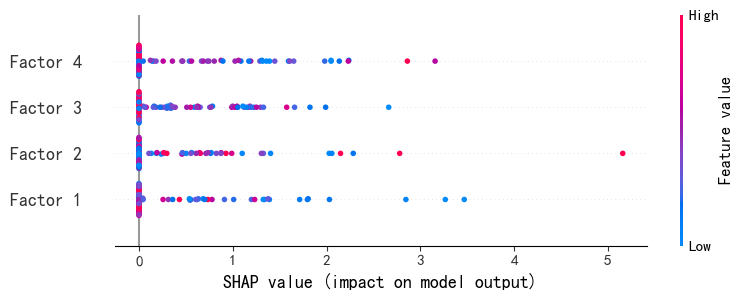

In [15]:
# 只保留正向 SHAP 值（用于 summary_plot）
shap_values_positive_only = shap_values_2d.copy()
shap_values_positive_only[shap_values_positive_only < 0] = 0

# summary_plot 只显示正值影响
shap.summary_plot(shap_values_positive_only, features=X, feature_names=data.columns[1:], plot_type="dot")


In [58]:
# 每列取平均绝对值（表示特征重要性）
mean_importance = np.abs(shap_values_2d).mean(axis=0)

# 对应列名
features = data.columns[1:]  # ['Factor 1', 'Factor 2', 'Factor 3', 'Factor 4']

# 打印特征重要性排序
for name, value in sorted(zip(features, mean_importance), key=lambda x: -x[1]):
    print(f"{name}: {value:.4f}")


Factor 3: 1.0153
Factor 4: 0.8443
Factor 2: 0.7772
Factor 1: 0.7098


In [29]:
shap_values_array = shap_values[0].reshape(-1)# .numpy()

# 绘图（使用原始未标准化特征 X）
# shap.summary_plot(shap_values_array, features=X, feature_names=data.columns[1:], plot_type="bar")
shap.summary_plot(shap_values_array, features=X, feature_names=data.columns[1:])

C:\Users\admin\AppData\Local\Temp\ipykernel_20968\357538948.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_array, features=X, feature_names=data.columns[1:])


AssertionError: Summary plots need a matrix of shap_values, not a vector.

In [33]:
shap_values_array

array([[ 0.77921557,  0.10962237,  0.41984963, -1.13196808]])

In [24]:
data.columns[1:]

Index(['Factor 1', 'Factor 2', 'Factor 3', 'Factor 4'], dtype='object')

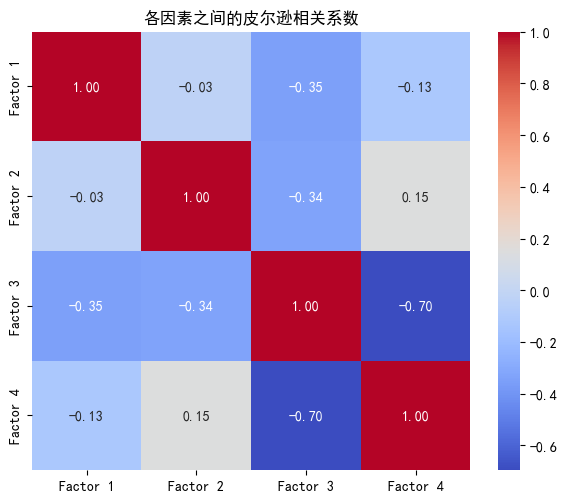

In [21]:
# 只看因子之间的相关性
import seaborn as sns
corr = data[['Factor 1', 'Factor 2', 'Factor 3', 'Factor 4']].corr(method='pearson')

# 可视化热力图
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('各因素之间的皮尔逊相关系数')
plt.tight_layout()
plt.show()


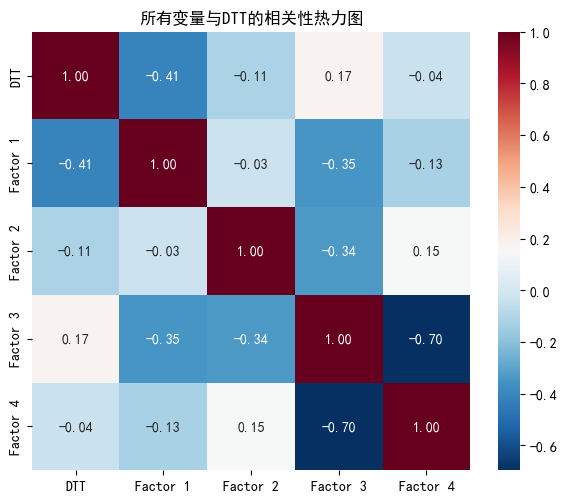

In [22]:
# 包括DTT本身
corr_with_target = data.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_with_target, annot=True, cmap='RdBu_r', fmt='.2f', square=True)
plt.title('所有变量与DTT的相关性热力图')
plt.tight_layout()
plt.show()
